In [ ]:
!pip install datasets
!pip install transformers==4.31.0
!pip install -U accelerate
!pip install optuna
!pip install optuna-dashboard

In [2]:
import transformers

transformers.__version__

'4.31.0'

#Data

In [3]:
preprocessing_column = "Light Stemming"

In [4]:
import pickle

with open('train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('val.pkl', 'rb') as f:
    X_dev = pickle.load(f)

In [5]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}

classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [6]:
X_train.head()

,tweet,label,tweet_with_replaced_emojis,cleaned_data_with_replaced_emojis,Light Stemming
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره اجرب اكون ليك اقرب
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [7]:
X_train = X_train[['tweet', preprocessing_column, 'label']]
y_train = X_train['label']
X_test = X_test[['tweet', preprocessing_column, 'label']]
y_test = X_test['label']
X_dev = X_dev[['tweet', preprocessing_column, 'label']]
y_dev = X_dev['label']

In [8]:
X_train.shape, X_test.shape, X_dev.shape

((7045, 3), (1510, 3), (1510, 3))

In [9]:
X_train

,tweet,Light Stemming,label
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...,1
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...,3
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,3
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,3
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,0
...,...,...,...
5734,احمد الاحمر اوحش لاعب في الاوليمبياد ... اخره ...,احمد الاحمر اوحش لاعب الاوليمبياد اخره تضخيم ا...,3
5191,انتي كان قصدك عليا !,انتي قصدك عليا,6
5390,يا جدعان لو سمحتوا مش كل واحد عنده ميتين ام عق...,جدع سمحت مش واحد ميت ام عقده نفسيه يروح داخل ش...,1
860,هتودينا في دهيا يا بلال ارحمنا ده مش وقت قلش,هتودي دهيا يابلال ارحم مش قلش,1


In [10]:
X_train = X_train.rename_axis('id')
X_test = X_test.rename_axis('id')
X_dev = X_dev.rename_axis('id')

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)

In [11]:
from datasets import Dataset

X_train = Dataset.from_pandas(X_train)
X_test = Dataset.from_pandas(X_test)
X_dev = Dataset.from_pandas(X_dev)
X_train, X_test, X_dev

(Dataset({
     features: ['tweet', 'Light Stemming', 'label'],
     num_rows: 7045
 }),
 Dataset({
     features: ['tweet', 'Light Stemming', 'label'],
     num_rows: 1510
 }),
 Dataset({
     features: ['tweet', 'Light Stemming', 'label'],
     num_rows: 1510
 }))

#Transformer

##Setup

In [12]:
model_checkpoint = 'UBC-NLP/MARBERTv2'

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [14]:
def tokenize_function(examples):
    return tokenizer(examples[preprocessing_column], padding="max_length", truncation=True, max_length=37)

X_train = X_train.map(tokenize_function, batched=True, num_proc = 8)
X_dev = X_test.map(tokenize_function, batched=True, num_proc = 8)
X_test = X_test.map(tokenize_function, batched=True, num_proc = 8)

Map (num_proc=8):   0%|          | 0/7045 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1510 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1510 [00:00<?, ? examples/s]

##Model

###Train

In [15]:
import numpy as np
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score
                             )

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_precision = precision_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_recall = recall_score(p.label_ids,preds,average='macro', zero_division=1)
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

In [16]:
import optuna
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW


def objective(trial: optuna.Trial):
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)
    # optimizer = AdamW(model.parameters(), lr=1e-5)
    training_args = TrainingArguments(
        output_dir="./train",
        learning_rate=trial.suggest_float("learning_rate", low=1e-5, high=5e-5, log=True),
        # learning_rate = 5.9572096694887074e-05,
        weight_decay=trial.suggest_float("weight_decay", 0.0, 0.1),
        num_train_epochs=trial.suggest_int("num_train_epochs", low=1, high=5),
        # num_train_epochs=4,
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        # per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        # seed = 34,
        seed=trial.suggest_int("seed", 10, 35),
        logging_steps = 100,
        load_best_model_at_end=True,
        evaluation_strategy="steps",
        metric_for_best_model = 'macro_f1' # relative to training metrics to prevent overfitting
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=X_train,
        eval_dataset=X_dev,
        compute_metrics=compute_metrics,
        # optimizers=(optimizer, None)
    )
    result = trainer.train()
    metrics = trainer.evaluate()
    return metrics["eval_macro_f1"], result.training_loss

In [17]:
# Run optimization
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage,
                            study_name="hyper-parameter-search",
                            directions=["maximize", "minimize"],
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=2)

[I 2023-08-23 19:32:20,556] A new study created in memory with name: hyper-parameter-search


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.676100,1.217130,0.562839,0.708064,0.612588,0.633775
200,1.105600,0.942192,0.690735,0.720445,0.698578,0.709934
300,0.893400,0.861638,0.710934,0.735456,0.716817,0.726490
400,0.794900,0.811520,0.731362,0.742631,0.735543,0.743046
500,0.674200,0.802525,0.729551,0.747377,0.733067,0.741060
600,0.623800,0.785013,0.738535,0.747032,0.738587,0.744371


[I 2023-08-23 19:35:46,392] Trial 0 finished with values: [0.7295509042526815, 0.9309264308187217] and parameters: {'learning_rate': 1.8224932432167997e-05, 'weight_decay': 0.03958687181530514, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 32}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.541700,1.094203,0.600730,0.680158,0.638722,0.655629
200,1.012600,0.858905,0.704604,0.733491,0.713871,0.725166
300,0.762500,0.821855,0.730098,0.753467,0.732206,0.740397
400,0.702600,0.758829,0.742533,0.760845,0.742458,0.749669
500,0.561300,0.781018,0.744413,0.755014,0.744535,0.747682
600,0.488400,0.789585,0.751114,0.757736,0.750734,0.754305
700,0.421600,0.790133,0.755038,0.762079,0.754192,0.756954
800,0.356600,0.807098,0.745083,0.750440,0.743718,0.746358


[I 2023-08-23 19:40:11,750] Trial 1 finished with values: [0.7444129804570899, 0.6934898557706116] and parameters: {'learning_rate': 2.6306873347434097e-05, 'weight_decay': 0.02843072661420716, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'seed': 28}. 


In [21]:
import optuna
import threading
from google.colab import output
from optuna_dashboard import run_server

# Start Optuna Dashboard
port = 8090
thread = threading.Thread(target=run_server, args=(storage,), kwargs={"port": port})
thread.start()
output.serve_kernel_port_as_window(port, path='/dashboard/')

<IPython.core.display.Javascript object>

Bottle v0.12.25 server starting up (using WSGIRefServer())...
Listening on http://localhost:8090/
Hit Ctrl-C to quit.



###Best Parameters

In [32]:
print(study.best_trials[0].params)

{'learning_rate': 2.6306873347434097e-05, 'weight_decay': 0.02843072661420716, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'seed': 28}


127.0.0.1 - - [23/Aug/2023 19:48:16] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304


In [33]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)
training_args = TrainingArguments(output_dir="./results",
                                  logging_steps = 100,
                                  evaluation_strategy="steps")
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=X_train,
                  eval_dataset=X_dev,
                  compute_metrics=compute_metrics)

127.0.0.1 - - [23/Aug/2023 19:48:44] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
127.0.0.1 - - [23/Aug/2023 19:48:46] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304


In [35]:
for n, v in study.best_trials[0].params.items():
    setattr(trainer.args, n, v)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.509400,1.046439,0.658400,0.718025,0.672612,0.687417
200,0.974100,0.862263,0.705758,0.741256,0.711610,0.723179
300,0.761800,0.809483,0.730260,0.744708,0.733002,0.739073
400,0.676800,0.779843,0.733752,0.749655,0.731745,0.738411
500,0.585000,0.786709,0.750933,0.755107,0.749535,0.752318
600,0.463500,0.789383,0.748927,0.754345,0.748283,0.750331
700,0.436400,0.796525,0.757502,0.764635,0.757372,0.760927
800,0.361800,0.803605,0.752855,0.755246,0.752595,0.753642


127.0.0.1 - - [23/Aug/2023 19:49:03] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:07] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:10] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:13] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:16] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:20] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:24] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
127.0.0.1 - - [23/Aug/2023 19:49:25] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304
/usr/local/lib/python3.10/dist-packages/optuna/study/_study_summary.py:115: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v5.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - -

TrainOutput(global_step=884, training_loss=0.6850561901455012, metrics={'train_runtime': 255.7067, 'train_samples_per_second': 110.204, 'train_steps_per_second': 3.457, 'total_flos': 535840140354240.0, 'train_loss': 0.6850561901455012, 'epoch': 4.0})

In [36]:
trainer.evaluate()

127.0.0.1 - - [23/Aug/2023 19:53:22] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304


{'eval_loss': 0.8067366480827332,
 'eval_macro_f1': 0.7574766463433232,
 'eval_macro_precision': 0.7630527587456827,
 'eval_macro_recall': 0.7568904489764391,
 'eval_accuracy': 0.7602649006622516,
 'eval_runtime': 4.4998,
 'eval_samples_per_second': 335.572,
 'eval_steps_per_second': 42.002,
 'epoch': 4.0}

###Evaluate

####Test Data

In [40]:
import torch

batch_size = 16

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [41]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_test]
attention_masks = [i['attention_mask'] for i in X_test]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
test_data = TensorDataset(inputs, masks)

test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [42]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

test_pred = []
for input, masks in test_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    test_pred.extend(predictions)

print(classification_report(X_test['label'], test_pred, target_names=classes))

/usr/local/lib/python3.10/dist-packages/optuna/study/_study_summary.py:115: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v5.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - - [23/Aug/2023 19:53:57] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304


              precision    recall  f1-score   support

        none       0.69      0.85      0.76       229
       anger       0.73      0.80      0.77       200
         joy       0.68      0.60      0.63       205
     sadness       0.67      0.64      0.66       185
        love       0.82      0.79      0.81       193
    sympathy       0.90      0.90      0.90       156
    surprise       0.66      0.53      0.59       154
        fear       0.94      0.94      0.94       188

    accuracy                           0.76      1510
   macro avg       0.76      0.76      0.76      1510
weighted avg       0.76      0.76      0.76      1510



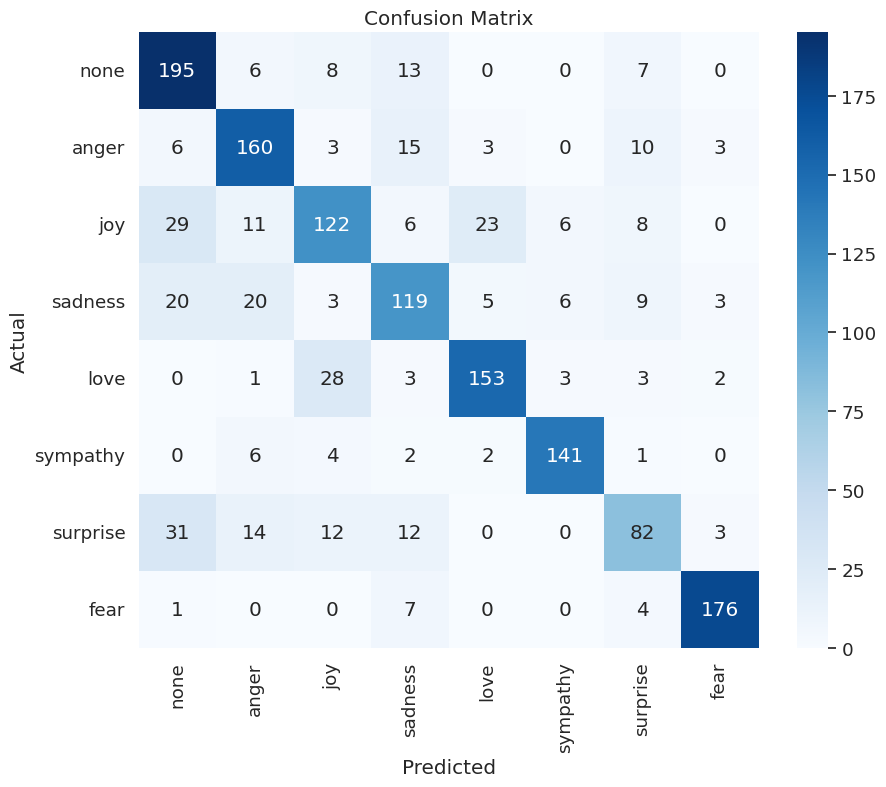

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_test['label'], test_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

####Train Data

In [44]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_train]
attention_masks = [i['attention_mask'] for i in X_train]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
train_data = TensorDataset(inputs, masks)

train_dataloader = DataLoader(train_data, batch_size=batch_size)

In [45]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

train_pred = []
for input, masks in train_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    train_pred.extend(predictions)

print(classification_report(X_train['label'], train_pred, target_names=classes))

/usr/local/lib/python3.10/dist-packages/optuna/study/_study_summary.py:115: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v5.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - - [23/Aug/2023 19:54:09] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304


              precision    recall  f1-score   support

        none       0.89      0.97      0.93      1074
       anger       0.93      0.98      0.95      1019
         joy       0.90      0.92      0.91       891
     sadness       0.92      0.92      0.92       885
        love       0.96      0.92      0.94       850
    sympathy       0.98      0.98      0.98       755
    surprise       0.92      0.77      0.84       729
        fear       0.99      0.96      0.98       842

    accuracy                           0.93      7045
   macro avg       0.94      0.93      0.93      7045
weighted avg       0.93      0.93      0.93      7045



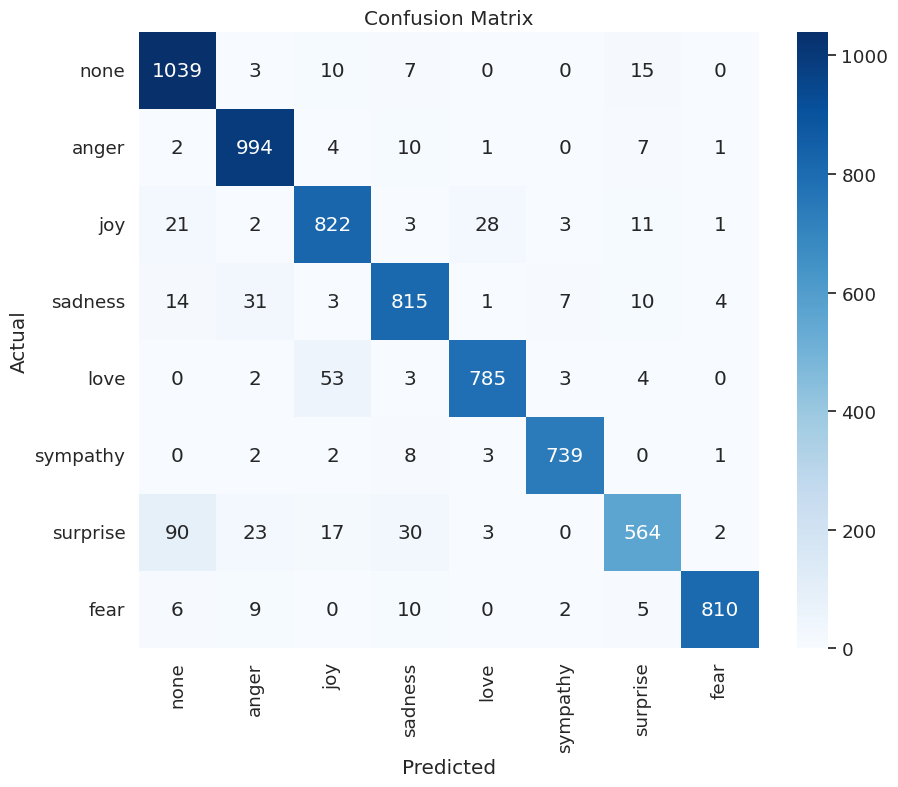

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_train['label'], train_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

####Dev Data

In [47]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_dev]
attention_masks = [i['attention_mask'] for i in X_dev]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
dev_data = TensorDataset(inputs, masks)

dev_dataloader = DataLoader(dev_data, batch_size=batch_size)

In [48]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

dev_pred = []
for input, masks in dev_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    dev_pred.extend(predictions)

print(classification_report(X_dev['label'], dev_pred, target_names=classes))

/usr/local/lib/python3.10/dist-packages/optuna/study/_study_summary.py:115: FutureWarning: `system_attrs` has been deprecated in v3.1.0. The removal of this feature is currently scheduled for v5.0.0, but this schedule is subject to change. See https://github.com/optuna/optuna/releases/tag/v3.1.0.
  warnings.warn(
127.0.0.1 - - [23/Aug/2023 19:54:22] "GET /api/studies/0?after=2 HTTP/1.1" 200 3304


              precision    recall  f1-score   support

        none       0.69      0.85      0.76       229
       anger       0.73      0.80      0.77       200
         joy       0.68      0.60      0.63       205
     sadness       0.67      0.64      0.66       185
        love       0.82      0.79      0.81       193
    sympathy       0.90      0.90      0.90       156
    surprise       0.66      0.53      0.59       154
        fear       0.94      0.94      0.94       188

    accuracy                           0.76      1510
   macro avg       0.76      0.76      0.76      1510
weighted avg       0.76      0.76      0.76      1510



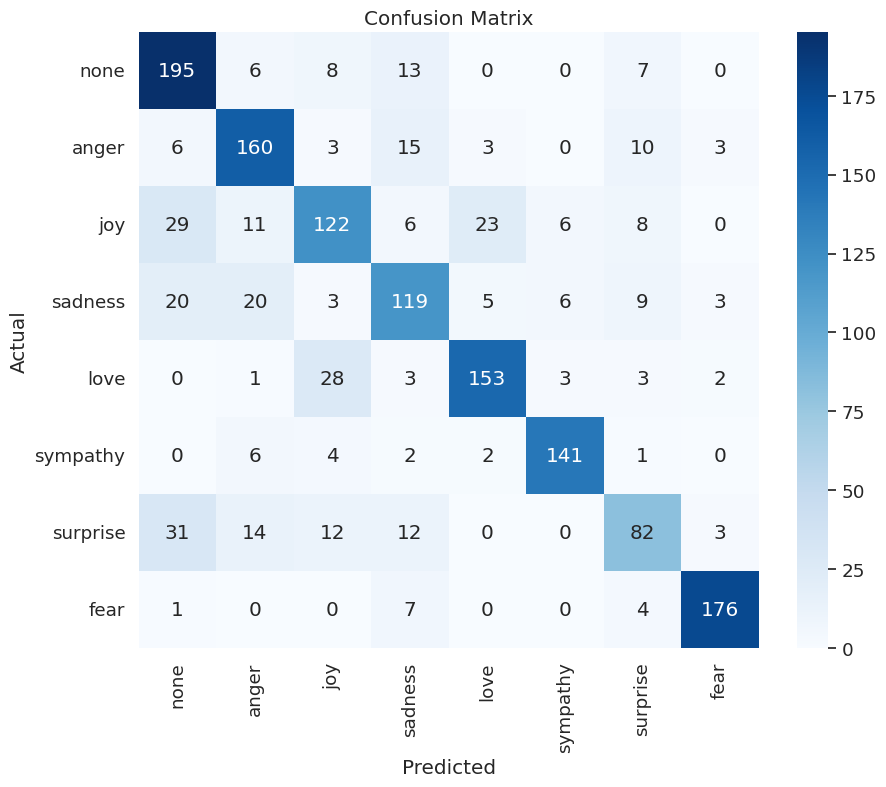

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_dev['label'], dev_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()